# Project 3 Lung Images Segmentation Model 

• Build an image segmentation model using pytorch

paper to study: Automatic Head Overcoat Thickness Measure with NASNet-Large-Decoder Net youshan zhang

we have 800 images in the training folder and 200 in the test folder

In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from torchmetrics.classification import BinaryAccuracy

###  Train your model using lung segmentation datasets

To set up the data loading part, we are going to create a class with the name SegmentationDataset, and inherit it from Dataset. 

In [2]:
TRAIN_IMG_DIR = 'Train/Images/'
TRAIN_MASK_DIR = 'Train/Masks/'
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, is_train, transform=None):
        self.img_dir  = img_dir
        self.mask_dir = mask_dir
        self.transform  = transform
        if is_train == True:
            x = round(len(os.listdir(img_dir)) * .8)
            self.images = os.listdir(img_dir)[:x]
        else:
            x = round(len(os.listdir(img_dir)) * .8)
            self.images = os.listdir(img_dir)[x:]
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        img_path    = os.path.join(self.img_dir, self.images[index])
        mask_path   = os.path.join(self.mask_dir, self.images[index])
        img         = np.array(Image.open(img_path).convert("L"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]
        return img, mask

In [4]:
LEARNING_RATE = 3e-4
BATCH_SIZE    = 64
IMAGE_HEIGHT  = 256  
IMAGE_WIDTH   = 192  

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)

In [5]:
def get_loaders( img_path, mask_path,batch_size, train_transform, val_tranform ):
    
    train_ds     = SegmentationDataset( img_dir=img_path, mask_dir=mask_path,
                            is_train=True, transform=train_transform)

    train_loader = DataLoader( train_ds, batch_size=batch_size, shuffle=True )

    val_ds       = SegmentationDataset( img_dir=img_path, mask_dir=mask_path,
                            is_train=False, transform=val_transform)

    val_loader   = DataLoader( val_ds, batch_size=batch_size, shuffle=True  )

    return train_loader, val_loader

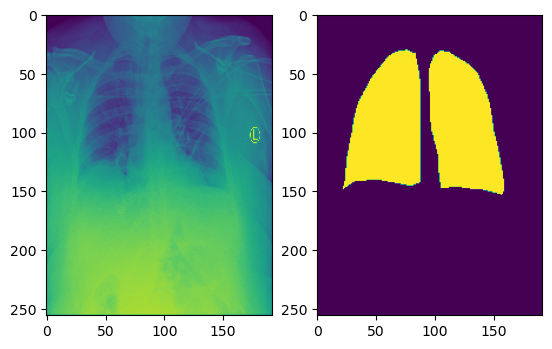

In [6]:
train_loader, val_loader = get_loaders(TRAIN_IMG_DIR, TRAIN_MASK_DIR, BATCH_SIZE, train_transform, val_transform)
inputs, masks = next(iter(train_loader))
_, ax = plt.subplots(1,2)
ax[0].imshow(inputs[0].permute(1,2,0))
ax[1].imshow(masks[0])

In [7]:
len(train_loader)

10

In [8]:
len(val_loader)

3

In [9]:
class double_conv2d_bn(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,strides=1,padding=1):
        super(double_conv2d_bn,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,
                               kernel_size=kernel_size,
                              stride = strides,padding=padding,bias=True)
        self.conv2 = nn.Conv2d(out_channels,out_channels,
                              kernel_size = kernel_size,
                              stride = strides,padding=padding,bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

In [10]:
class deconv2d_bn(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=2,strides=2):
        super(deconv2d_bn,self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels,out_channels,
                                        kernel_size = kernel_size,
                                       stride = strides,bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        return out

In [11]:
class U_net(nn.Module):
    def __init__(self):
        super(U_net,self).__init__()
        self.layer1_conv = double_conv2d_bn(1,8)
        self.layer2_conv = double_conv2d_bn(8,16)
        self.layer3_conv = double_conv2d_bn(16,32)
        self.layer4_conv = double_conv2d_bn(32,64)
        self.layer5_conv = double_conv2d_bn(64,128)
        self.layer6_conv = double_conv2d_bn(128,64)
        self.layer7_conv = double_conv2d_bn(64,32)
        self.layer8_conv = double_conv2d_bn(32,16)
        self.layer9_conv = double_conv2d_bn(16,8)
        self.layer10_conv = nn.Conv2d(8,1,kernel_size=3,
                                     stride=1,padding=1,bias=True)
        
        self.deconv1 = deconv2d_bn(128,64)
        self.deconv2 = deconv2d_bn(64,32)
        self.deconv3 = deconv2d_bn(32,16)
        self.deconv4 = deconv2d_bn(16,8)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        conv1 = self.layer1_conv(x)
        pool1 = F.max_pool2d(conv1,2)
        
        conv2 = self.layer2_conv(pool1)
        pool2 = F.max_pool2d(conv2,2)
        
        conv3 = self.layer3_conv(pool2)
        pool3 = F.max_pool2d(conv3,2)
        
        conv4 = self.layer4_conv(pool3)
        pool4 = F.max_pool2d(conv4,2)
        
        conv5 = self.layer5_conv(pool4)
        
        convt1 = self.deconv1(conv5)
        concat1 = torch.cat([convt1,conv4],dim=1)
        conv6 = self.layer6_conv(concat1)
        
        convt2 = self.deconv2(conv6)
        concat2 = torch.cat([convt2,conv3],dim=1)
        conv7 = self.layer7_conv(concat2)
        
        convt3 = self.deconv3(conv7)
        concat3 = torch.cat([convt3,conv2],dim=1)
        conv8 = self.layer8_conv(concat3)
        
        convt4 = self.deconv4(conv8)
        concat4 = torch.cat([convt4,conv1],dim=1)
        conv9 = self.layer9_conv(concat4)
        outp = self.layer10_conv(conv9)
        outp = self.sigmoid(outp)
        return outp

In [12]:
model = U_net()
inp = torch.rand(10,1,256,192)
outp = model(inp)
print(outp.shape)

torch.Size([10, 1, 256, 192])


In [13]:
model = model.to(DEVICE)

In [14]:
inputs, masks = next(iter(train_loader))
img = inputs[0].permute(1,2,0)
mask = masks[0]

In [15]:
img.shape

torch.Size([256, 192, 1])

In [16]:
mask.shape

torch.Size([256, 192])

In [17]:
#PyTorch
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU

In [18]:
iou = IoULoss()

In [19]:
def train_fn(loader, model):
    loop = tqdm(loader)
    loss_fn   = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    model.train()

    for batch_idx, (image, mask) in enumerate(loop):
        image   = image.to(DEVICE)
        mask    = mask.float().unsqueeze(1).to(DEVICE)

        # forward
        predictions = model(image)
        loss = loss_fn(predictions, mask)

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [20]:
EPOCHS    = 10
loss_fn   = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

valacc=[]
valloss=[]
for epoch in range(EPOCHS):

    print('epoch: '+str(epoch))
#     train_fn(train_loader, model)
    valid_loss = 0

    model.eval()

    with torch.no_grad():
        for img, mask in tqdm(val_loader):
            img   = img.to(DEVICE)
            mask  = mask.to(DEVICE).unsqueeze(1)
            out = model(img)
            loss = loss_fn(out,mask)
            valid_loss += loss.item()
            ret, predictions = torch.max(out.data, 1)
            mask = mask.squeeze(1)
            IOU =iou(mask, predictions)
        
        else:
            valloss.append(valid_loss/len(val_loader))
            valacc.append(IOU)
        
            # print accuracy and loss
            print('IOU Score', IOU)
            print(f"Validation loss: {valid_loss/len(val_loader)}") 
print("Learning Finished")
torch.save(model, 'UNET.pt')

epoch: 0


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\Jiuge\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.96s/it]


IOU Score tensor(1.1122e-06)
Validation loss: 0.8134865562121073
epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  2.00s/it]


IOU Score tensor(1.1162e-06)
Validation loss: 0.8142021497090658
epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  2.00s/it]


IOU Score tensor(1.1067e-06)
Validation loss: 0.8124898473421732
epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]


IOU Score tensor(1.1194e-06)
Validation loss: 0.8147576848665873
epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.04s/it]


IOU Score tensor(1.1226e-06)
Validation loss: 0.8153245647748312
epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.09s/it]


IOU Score tensor(1.1153e-06)
Validation loss: 0.8140378991762797
epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.10s/it]


IOU Score tensor(1.1036e-06)
Validation loss: 0.8119268218676249
epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.08s/it]


IOU Score tensor(1.1106e-06)
Validation loss: 0.8131886919339498
epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.02s/it]


IOU Score tensor(1.1091e-06)
Validation loss: 0.8129198352495829
epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.06s/it]

IOU Score tensor(1.1132e-06)
Validation loss: 0.8136669993400574
Learning Finished


Text(0.5, 1.0, 'Validation IOU Score')

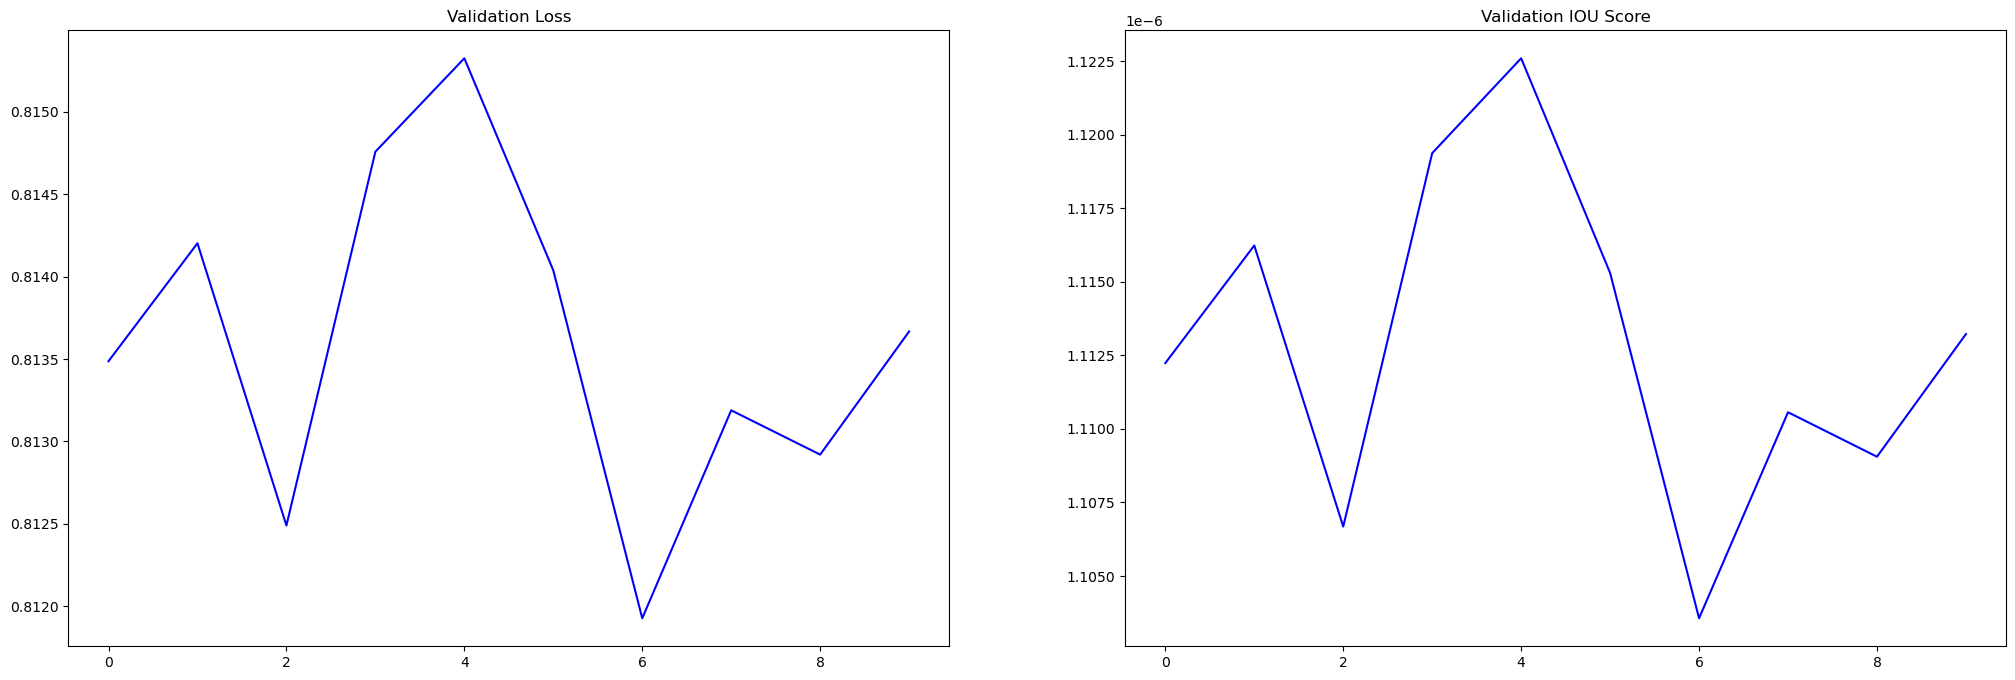

In [21]:
e = [i for i in range(0,EPOCHS)]
plt.figure(figsize =(25,8))
plt.subplot(1,2,1)
plt.plot(e, valloss, c='b')
plt.title('Validation Loss')

plt.subplot(1,2,2)
plt.plot(e, valacc, c='b')
plt.title('Validation IOU Score')

In [22]:
TEST_IMG_DIR = 'Test/Images/'
TEST_MASK_DIR = 'Test/Masks/'
batch_size=16
test_ds     = SegmentationDataset( img_dir=TEST_IMG_DIR, mask_dir=TEST_MASK_DIR,
                            is_train=True, transform=train_transform)
test_loader = DataLoader( test_ds, batch_size=batch_size, shuffle=True )

In [23]:
# test the dataset
with torch.no_grad():
    for img, mask in tqdm(test_loader):
        img   = img.to(DEVICE)
        mask  = mask.to(DEVICE).unsqueeze(1)
        out = model(img)
        ret, predictions = torch.max(out.data, 1)
    IOU =iou(mask, predictions)
    print("Test IOU score:", IOU)       

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]

Test IOU score: tensor(2.1921e-06)


###  Evaluate your model using the test images

### Your IoU score should be higher than 0.82
The intersection over union (IoU) is also known as the Jaccard index. Using IoU implies that we have two images to compare: one is our prediction and the other one is the ground truth, if the value obtained approaches number 1 that means the prediction is similar and close to our ground truth. And vice versa, the lower IoU, the worst our results.

###  Write a two-page report using LaTex and upload your paper to 
ResearchGate or Arxiv.